In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

import pymc3 as pm
import cvxpy as cp

from plotting import *

import os
import sys

# Abstract model class

In [2]:
class PredictionModel:
    '''
    Abstract model class for pymc3 models of future returns.
    '''
    
    def __init__(self):
        
        self.data_set = False
        
    
    #############################################################################################################
    
    # There are several ways we might want to feed data into the models. Option 1 is to generate the returns csv
    # using the raw data. Option 2 is to read in a returns csv that has already been created. 
    
    def process_raw_data(self, overwrite=False, output_fname="log_returns.csv"):
        '''
        Processes the raw input data.
        '''
        # Check that we haven't done this already
        if (self.data_set == True) and (overwrite == False):
            raise Exception("You are about to overwrite data that has already been set. Call with overwrite=True to confirm.")
        
        # Change directory
        os.chdir(sys.path[0]+"/raw_data")

        # Read in files and grab daily close prices
        df = pd.DataFrame(data={"returns"})
        for n, fname in enumerate(os.listdir()):
            if n == 0:
                ticker = fname.split(".csv")[0]
                df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
            else:
                ticker = fname.split(".csv")[0]
                temp_df = pd.read_csv(fname, index_col="Date", parse_dates=True)[["Adj Close"]].rename(columns={"Adj Close" : ticker})
                df = pd.merge(df, temp_df, left_index=True, right_index=True)

        # Save copy of the raw data
        self.raw_df = df.copy()
        
        # Convert to daily log returns
        df = np.log(df) - np.log(df.shift(1))
        df = df.dropna()

        # Go back up a directory and save
        os.chdir(sys.path[0])
        df.to_csv(output_fname)
        
        # Save to object
        self.df = df.copy()
        self.data_set = True
        self.calc_data_stats()
        
    def read_data(self, overwrite=False, input_fname="log_returns.csv"):
        # Check that we haven't done this already.
        if (self.data_set == True) and (overwrite == False):
            raise Exception("You are about to overwrite data that has already been set. Call with overwrite=True to confirm.")
        
        # Read returns from file.
        self.df = pd.read_csv(input_fname, index_col="Date", parse_dates=True)
        self.data_set = True
        self.calc_data_stats()
        
    def calc_data_stats(self):
        '''
        Given the input data, computes some basic statistics.
        '''
        # Get shape of the data
        self.nobs, self.ndim = self.df.shape
        
        # Store time index
        self.data_start_date = min(self.df.index)
        self.data_end_date = max(self.df.index)
        
        # Store names
        self.algo_names = self.df.columns
        
    def train_test_split(self, perc=0.7):
        '''
        Splits data into testing and training segments.
        '''
        # Pick cutoff point
        idx = int(perc*self.nobs)
        
        # Store data
        self.train_df = self.df[:idx].copy()
        self.test_df = self.df[idx:].copy()
        self.train = self.train_df.values
        self.test = self.test_df.values
        self.ntrain = len(self.train_df)
        self.ntest = len(self.test_df)
        
        # Also store raw data copies
        self.raw_train_df = self.raw_df[:idx+1].copy()
        self.raw_test_df = self.raw_df[idx+1:].copy()
        
    #####################################################
    # Running the models
    #####################################################
    
    def sample_model(self, samples=4000, ncores=1):
        '''
        Samples the posterior distribution over model parameters and saves the output.
        '''
        os.chdir(sys.path[0])
        with self.model:
            self.trace = pm.sample(samples, cores=ncores)
        trace_1 = pm.save_trace(self.trace, directory=sys.path[0]+"/sampling_traces/"+"{}/".format(self.name), overwrite=True)
                                
    def load_trace(self):
        '''
        Loads in a pre-sampled trace for the model.
        '''
        self.trace = pm.load_trace(sys.path[0]+"/sampling_traces/"+"{}/".format(self.name), model=self.model)
    
    #####################################################
    # Optimization
    #####################################################
    
    def loss_and_optimize(self, lam=1.0):
        '''
        Defines the loss optimization problem to solve with cvxpy, and returns the solution.
        '''

        # Setup the loss function
        w = cp.Variable(self.ndim)
        loss = cp.sum( -1.0*cp.exp( -lam*( self.pred_ending_returns @ w ) ) )
        prob = cp.Problem(cp.Maximize(loss), 
                           [cp.sum(w) == 1, 
                            w >= 0])

        # Solve the problem
        #prob.solve(solver=cp.SCS, max_iters=5000, eps=1e-6)
        prob.solve(solver=cp.SCS)
        sol = w.value

        # Save solution
        weight_dict = dict(zip(self.algo_names, sol))

        os.chdir(sys.path[0]+"/optimal_weights/")
        with open('{}_lam_{}.csv'.format(self.name, lam), 'w') as f:
            # Overwrite any existing data
            f.truncate(0)
            for key in weight_dict.keys():
                f.write("%s,%s\n"%(key,weight_dict[key]))

        return None
    
    #####################################################
    # Generate plots
    #####################################################
    
    def gen_plots(self):
        '''
        Generates a bunch of plots
        '''
        # Test-train split
        plot_test_train_ret(self.train_df, self.test_df, self.name)
        plot_test_train_raw(self.raw_train_df, self.raw_test_df, self.name)
        
        # Plot cumalative return sample paths
        plot_algo_cum_returns(self.pred_cum_returns, self.algo_names, self.name, num=1000)
        plot_bayes_cone_cum_ret(self.train_df, self.test_df, self.pred_raw_log_returns, self.name, self.algo_names, prev_days="all")
        plot_bayes_cone_bal(self.train_df, self.raw_train_df, self.test_df, self.raw_test_df, self.pred_raw_log_returns, self.name, self.algo_names, fidx="same", prev_days="all")

# Multivariate StudentT Model subclass

In [3]:
class MultStudentT(PredictionModel):
    '''
    Implements the multivariate student t model.
    
    All models must implement build_model and compute_forecast.
    '''
    def __init__(self, name="model1"):
        super().__init__()
        self.name = name
        self.model_type = "multivariate student t"
    
    
    def build_model(self):
        '''
        Defines the model for returns.
        '''
        with pm.Model() as self.model:
            
            # Compute correlation matrix
            chol, corr, stds = pm.LKJCholeskyCov(
                "chol", n=self.ndim, eta=2.0, sd_dist=pm.Exponential.dist(1.0), compute_corr=True
            )
            chol2 = pm.Deterministic("chol2", chol)
            cov = pm.Deterministic("cov", chol.dot(chol.T))
            mu = pm.Normal("mu", 0.0, 1.0, shape=self.ndim)
            nu1 = pm.HalfNormal("nu_minus_2", sigma=1)
            nu2 = pm.Deterministic("nu", 2.0+nu1)
            obs = pm.MvStudentT("obs", nu=nu2, mu=mu, chol=chol, observed=self.train_df, shape=(1,self.ndim))
    
    def compute_forecast(self, fdays="None"):
        '''
        Computes forecasting sample trajectories.
        '''
        if fdays == "None":
            fdays = len(self.test_df)
        
        nsamps = self.trace["nu"].shape[0] # number of MCMC samples

        # samples of nu
        nus = self.trace["nu"]

        # samples of mu
        mus = self.trace["mu"]

        # samples of the chol fact of the cov matrix
        chols = self.trace["chol2"]

        # Now, because of shape issues we need some new code to generate multiple samples across the different MCMC samples

        # # Generate samples from the standard multivariate normal distribution.
        dim = len(mus[0])
        samps_per_param = fdays # this can be seen as number of days
        zero_means = np.zeros(mus.shape)
        u = np.random.multivariate_normal(np.zeros(dim), np.eye(dim),
                                        size=(len(zero_means), samps_per_param,))
        # u has shape (len(means), nsamples, dim)

        # # Transform u.
        v = np.einsum('ijk,ikl->ijl', u, chols)
        m = np.expand_dims(zero_means, 1)
        t = v + m
        # Now t is distributed N(0, Cov) but is 3-dim, which is what we want

        # Now we need the normalization constants, which are sqrt(U/nu) where U is chi^2_nu distributed
        prefac = np.random.chisquare(nus)
        prefac /= nus
        prefac = np.sqrt(prefac)

        # Now broadcast to the N(0, Cov) samples
        offset = t/prefac[:,None,None]

        # Now add the true mean
        self.pred_raw_log_returns = mus[:,None,:] + offset
        self.pred_raw_returns = np.exp(self.pred_raw_log_returns) - 1.0

        # Calculate cumulative gains for each algo

        # But we actually have log returns, so its a cumsum instead of a cumprod.
        self.pred_cum_log_returns = self.pred_raw_log_returns.cumsum(axis=1)
        self.pred_cum_returns = np.exp(self.pred_cum_log_returns) - 1.0
        
        # Slice out the cumulative gain at the final time
        self.pred_ending_returns = self.pred_cum_returns[:,-1,:]
        self.pred_ending_log_returns = self.pred_cum_log_returns[:,-1,:]

In [6]:
# Create and sample new model
m = MultStudentT("test_model_1")
m.process_raw_data()
m.train_test_split(perc=0.95)
m.build_model()
m.sample_model()
m.compute_forecast()

C:\Users\Jonathan\anaconda3\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu_minus_2, mu, chol]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 70 seconds.


In [4]:
# or load in a previously-sampled model
m = MultStudentT("test_model_1")
m.process_raw_data()
m.train_test_split(perc=0.95)
m.build_model()
m.load_trace()
m.compute_forecast()

In [ ]:
m.loss_and_optimize()

TypeError: plot_bayes_cone_bal() missing 2 required positional arguments: 'model_name' and 'algo_names'

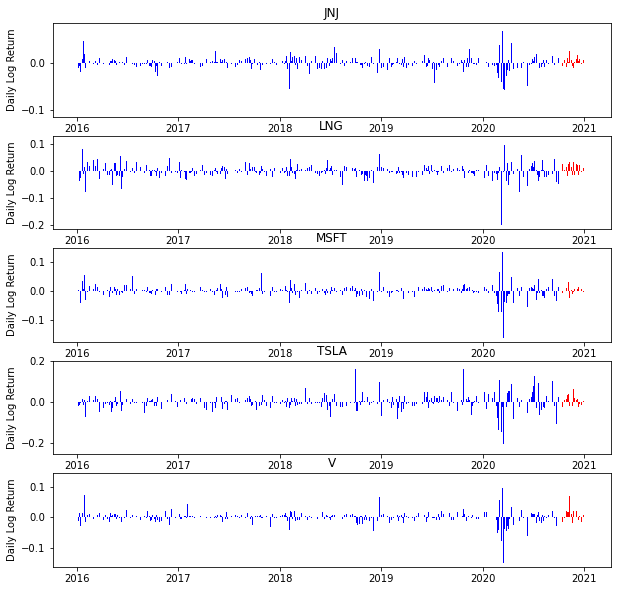

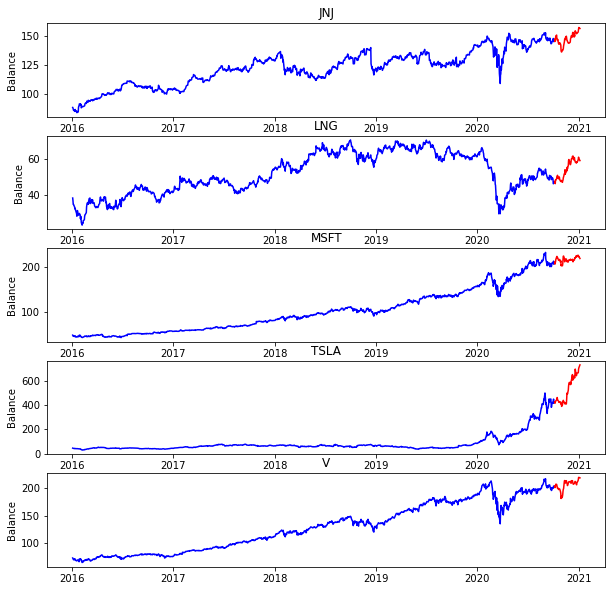

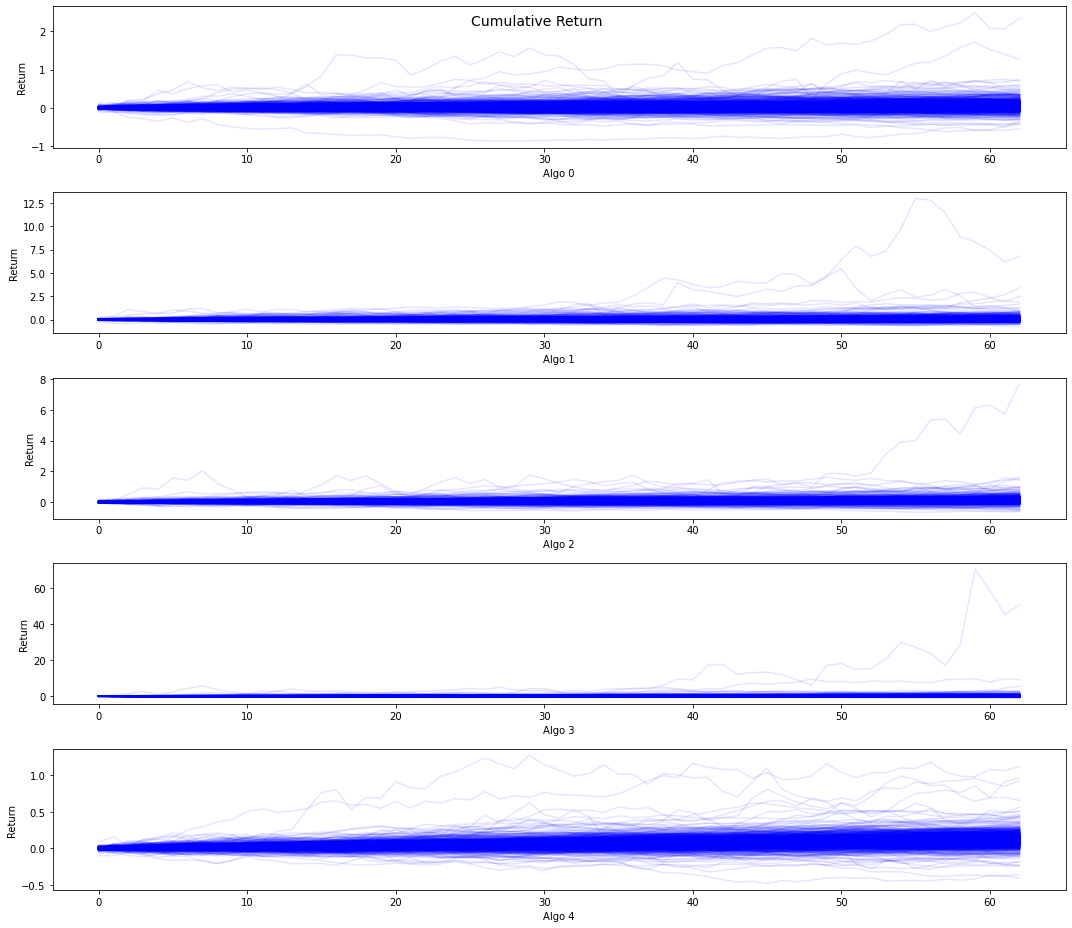

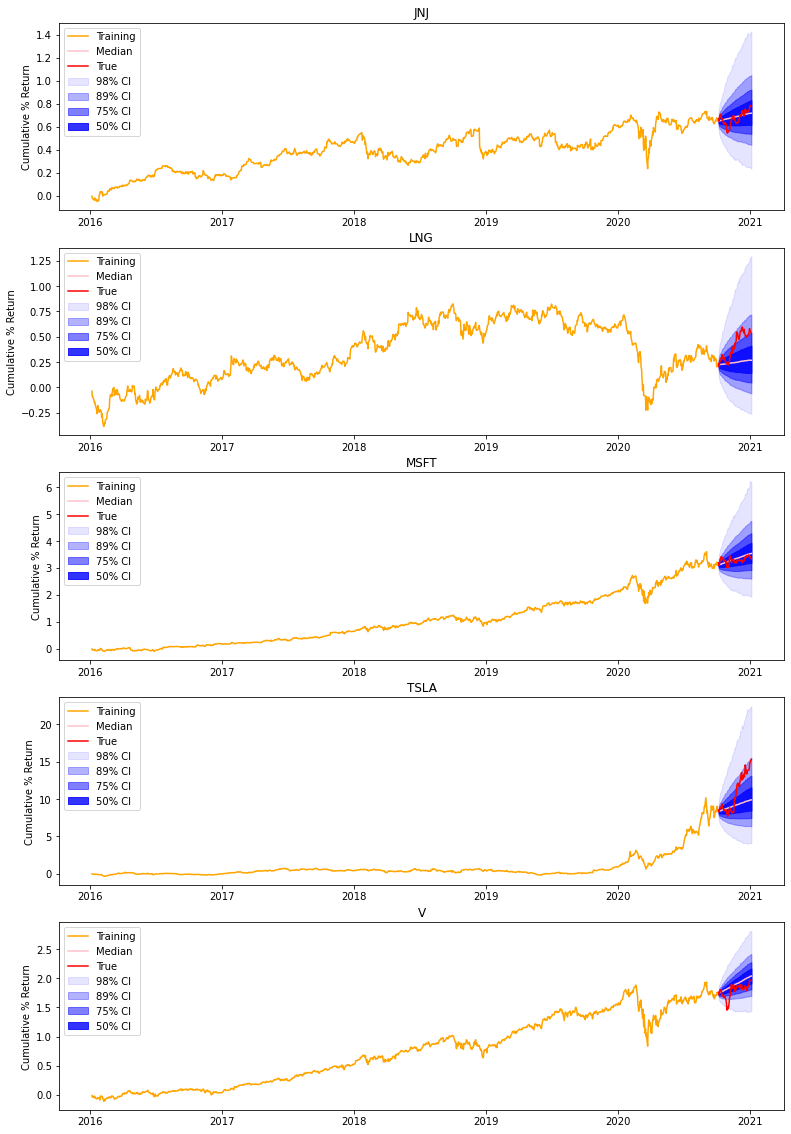

In [5]:
m.gen_plots()

In [159]:
def compute_bands(vals, levels=[1.0, 5.5, 12.5, 25, 75, 87.5, 94.5, 99.0]):
    '''
    Given an array with shape (x, y, z) where x is the dimension for samples, y is the 
    dimension for time, and z the dimension variable, computes the corresponding percentile bands for credible intervals.
    '''
    def scoreatpercentile(vals, p):
        return np.percentile(vals, p, axis=0)
    perc = {p:scoreatpercentile(vals,p) for p in levels}
    median = np.median(vals, axis=0)
    perc["median"] = median
    return perc

In [167]:
def plot_bayes_cone_ret(train_df, test_df, pred_raw_log_returns, model_name, algo_names, fidx="same", prev_days="all"):
    '''
    Plots the bayesian cone for forward-looking returns
    '''
    # Some params
    dim = pred_raw_log_returns.shape[2]
    cols = train_df.columns
    n_hist_days = train_df.shape[0]
    
    # Handle prediction index
    if fidx == "same":
        idx = test_df.index
    else:
        idx = fdix
    
    # Get cumulative return from training
    hist_cum_returns = np.exp(train_df.values.cumsum(axis=0))-1.0
    hist_idx = train_df.index
    if prev_days == "all":
        pass
    else:
        hist_cum_returns = hist_cum_returns[-prev_days:,:]
        hist_idx = hist_idx[-prev_days:]
    
    # Now compute future returns
    nsamps = pred_raw_log_returns.shape[0]
    mod_train = np.repeat(train_df.values[np.newaxis, :, :], nsamps, axis=0)
    full_samps = np.exp(np.concatenate([mod_train, pred_raw_log_returns], axis=1).cumsum(axis=1))-1.0
    future_samps = full_samps[:, n_hist_days:, :]
    bands = compute_bands(future_samps)
    
    # True returns.
    true_log_rets = np.concatenate([m.train, m.test])
    true_cum_rets = np.exp(true_log_rets.cumsum(axis=0))-1.0
    future_true = true_cum_rets[n_hist_days:, :]
    
    
    fig, axs = plt.subplots(dim, 1, figsize=(13, 4*dim))
    for j in range(dim):
        # Training data
        axs[j].plot(hist_idx, hist_cum_returns[:,j], color="orange", label="Training")
        
        # Predictions
        axs[j].fill_between(idx, bands[1.0][:,j], bands[99.0][:,j], alpha=0.1, color="b", label="98% CI")
        axs[j].fill_between(idx, bands[5.5][:,j], bands[94.5][:,j], alpha=0.3, color="b", label="89% CI")
        axs[j].fill_between(idx, bands[12.5][:,j], bands[87.5][:,j], alpha=0.5, color="b", label="75% CI")
        axs[j].fill_between(idx, bands[25][:,j], bands[75][:,j], alpha=0.8, color="b", label="50% CI")
        axs[j].plot(idx, bands["median"][:,j], alpha=1.0, color="pink", label="Median")
        
        # True path
        axs[j].plot(test_df.index, future_true[:,j], color="red", label="True")
        
        # Other plotting
        axs[j].set_title(algo_names[j])
        axs[j].legend()

    fig.savefig("{}_bayes_cone_ret.png".format(model_name), dpi=250)
    

In [30]:
def plot_bayes_cone_bal(train_df, raw_train_df, test_df, raw_test_df, pred_raw_log_returns, model_name, algo_names, fidx="same", prev_days="all"):
    '''
    Plots the bayesian cone for forward-looking balances of each algo.
    '''
    # Some params
    dim = pred_raw_log_returns.shape[2]
    cols = train_df.columns
    n_hist_days = train_df.shape[0]
    
    # Get cumulative return from training
    hist_bals = raw_train_df.values
    hist_idx = raw_train_df.index
    if prev_days == "all":
        pass
    else:
        hist_bals = hist_bals[-prev_days:,:]
        hist_idx = hist_idx[-prev_days:]
        
    # Handle prediction index
    if fidx == "same":
        idx = test_df.index
    else:
        idx = fdix
        
    # Now back out the implied forecasted balances
    nsamps = pred_raw_log_returns.shape[0]
    mod_train = np.repeat(train_df.values[np.newaxis, :, :], nsamps, axis=0)
    full_samps = np.exp(np.concatenate([mod_train, pred_raw_log_returns], axis=1).cumsum(axis=1))-1.0
    full_bals = raw_train_df.values[0,:]*(1.0+full_samps)
    future_bals = full_bals[:, n_hist_days:, :]
    bands = compute_bands(future_bals)
        
    
    fig, axs = plt.subplots(dim, 1, figsize=(13, 4*dim))
    for j in range(dim):
        # Training data
        axs[j].plot(hist_idx, hist_bals[:,j], color="orange", label="Training")
        
        # Predictions
        axs[j].fill_between(idx, bands[1.0][:,j], bands[99.0][:,j], alpha=0.1, color="b", label="98% CI")
        axs[j].fill_between(idx, bands[5.5][:,j], bands[94.5][:,j], alpha=0.3, color="b", label="89% CI")
        axs[j].fill_between(idx, bands[12.5][:,j], bands[87.5][:,j], alpha=0.5, color="b", label="75% CI")
        axs[j].fill_between(idx, bands[25][:,j], bands[75][:,j], alpha=0.8, color="b", label="50% CI")
        axs[j].plot(idx, bands["median"][:,j], alpha=1.0, color="pink", label="Median")
        
        # True path
        axs[j].plot(raw_test_df.index, raw_test_df.values[:,j], color="red", label="True")
        
        # Other plotting
        axs[j].set_title(algo_names[j])
        axs[j].set_ylabel("Balance ($)")
        axs[j].legend()
    
    plt.show()

In [153]:
# load in a previously-sampled model
m = MultStudentT("test_model_1")
m.process_raw_data()
m.train_test_split()
m.build_model()
m.load_trace()
m.compute_forecast()

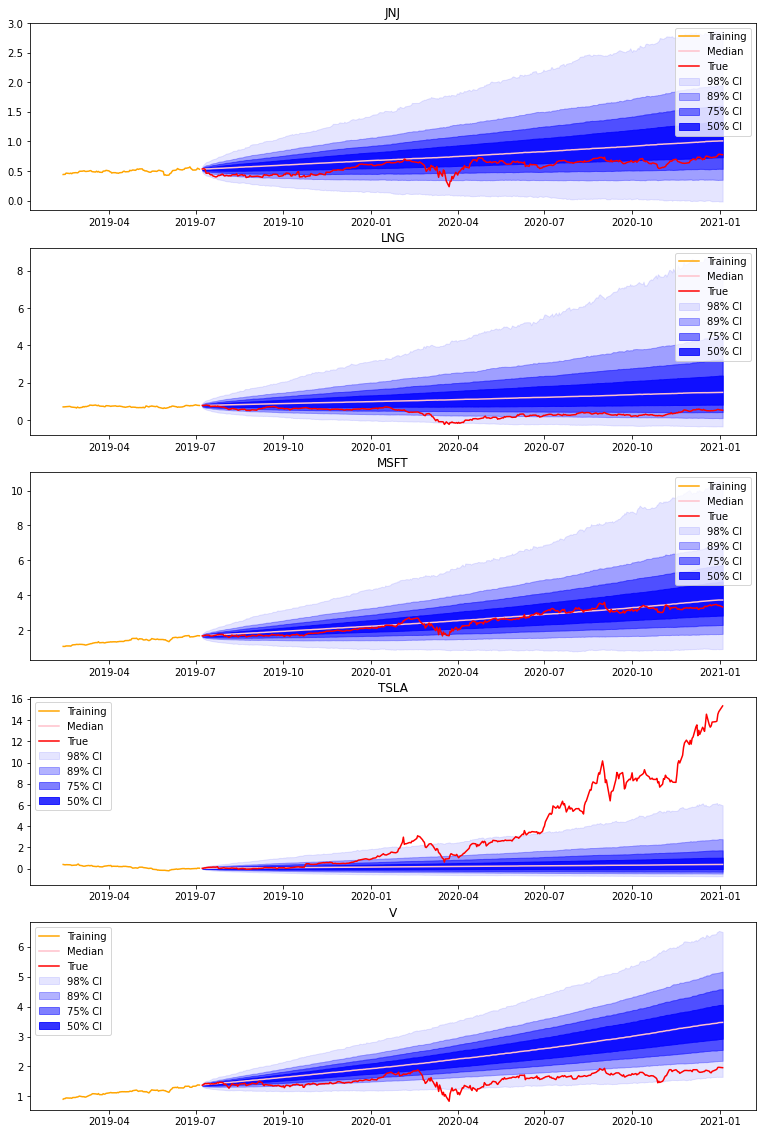

In [168]:
plot_bayes_cone_ret(m.train_df, m.test_df, m.pred_raw_log_returns, m.name, m.algo_names, prev_days=100)

In [90]:
np.expand_dims(m.train, axis=0).shape

(1, 880, 5)

In [95]:
np.concatenate([np.expand_dims(m.train, axis=0), m.pred_raw_log_returns], axis=1)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1 and the array at index 1 has size 8000

In [92]:
m.pred_raw_log_returns.shape

(8000, 378, 5)

In [84]:
# load in a previously-sampled model
m = MultStudentT("test_model_1")
m.process_raw_data()
m.train_test_split()
m.build_model()
m.load_trace()
m.compute_forecast()

In [78]:
bands = compute_bands(m.pred_cum_returns)
z = [i for i in range(bands[5.5].shape[0])]

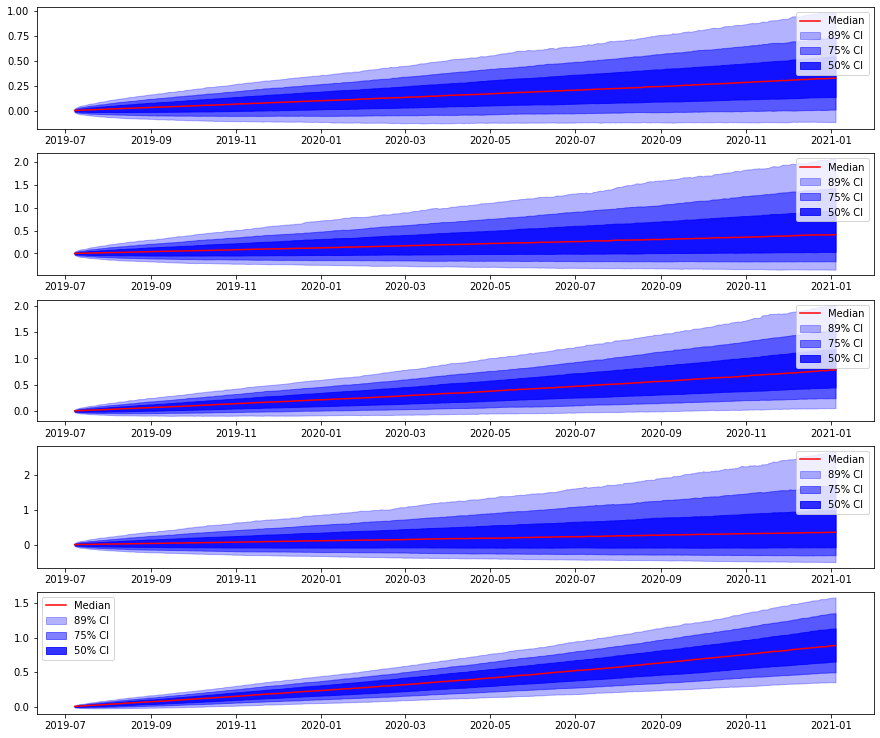

In [79]:
plot_bayes_cone_ret(m.pred_cum_returns, m.test_df.index)

In [80]:
def calc_cum_rets(df):
    '''
    Given a df of daily log returns, computes same df but with cumulative daily returns.
    '''
    return df.cumsum()

In [ ]:
m.train

In [63]:
m.train_df.cumsum()

,JNJ,LNG,MSFT,TSLA,V
Date,,,,,
2016-01-06,-0.005067,-0.037340,-0.018332,-0.019844,-0.013198
2016-01-07,-0.016790,-0.095388,-0.053734,-0.035441,-0.033057
2016-01-08,-0.027531,-0.094245,-0.050672,-0.057240,-0.045465
2016-01-11,-0.033560,-0.129714,-0.051246,-0.072282,-0.031296
2016-01-12,-0.026716,-0.139229,-0.042110,-0.062134,-0.019997
...,...,...,...,...,...
2019-06-28,0.416070,0.576225,0.963573,0.000134,0.848789
2019-07-01,0.416644,0.600329,0.976330,0.016600,0.851034
2019-07-02,0.421440,0.591160,0.982942,0.005000,0.858708


In [10]:
m.pred_cum_returns.shape

(8000, 378, 5)

In [35]:
bands = compute_bands(m.pred_cum_returns)

In [37]:
bands[5.5].shape

(378, 5)

In [19]:
bands["median"].shape

(378, 5)

In [21]:
m.pred_cum_returns.shape

(8000, 378, 5)

In [22]:
data= m.pred_cum_returns

In [26]:
np.percentile(data, 5, axis=0).shape

(378, 5)